In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('./Mall_Customers.csv')

# Mall Customer Clustering Project

Goals:
By the end of this case study , you would be able to answer below questions. 

1. How to achieve customer segmentation using machine learning algorithm (KMeans Clustering) in Python in simplest way.

2. Who are your target customers with whom you can start targeting with your marketing strategy

3. How the marketing strategy works in real world

## Overview

In [7]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


We have a few continuous variables and a categorical feature (gender). 

We should later drop the CustomerID column and convert the Gender column into a binary attribute. 

In [108]:
df.shape

(200, 5)

With 200 observations and 5 features (soon to be 4), we cna consider this as a small dataset with a focused goal. 

In [109]:
df.isna().sum().sum()

0

We have no missing values.

In [110]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


There doesn't seem to much out of the ordinary with this data. Considering how this is presumedly a sample of the customer population, we would benefit if the sample was randomly collected and resembled the population. 

In [8]:
temp = df.Gender.value_counts()
df['Gender'] = np.where(df['Gender'] == 'Female', 1, 0)

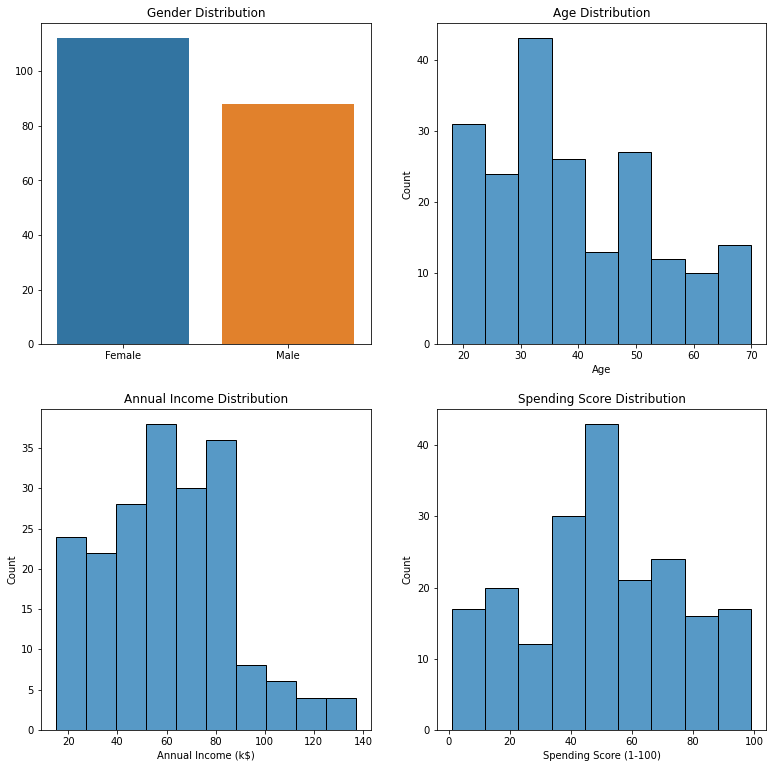

In [13]:
fig, ([ax1, ax2],[ax3, ax4])= plt.subplots(2,2, figsize = (13,13))

sns.barplot(x = temp.index, y = temp.values, ax = ax1)
sns.histplot(x = df['Age'], ax = ax2)
sns.histplot(x = df['Annual Income (k$)'], ax = ax3)
sns.histplot(x = df['Spending Score (1-100)'], ax = ax4)

ax1.set_title("Gender Distribution")
ax3.set_title("Annual Income Distribution")
ax2.set_title("Age Distribution")
ax4.set_title("Spending Score Distribution");

These features clearly have different distributions: gender is clearly Bernoulli. I

ncome and age have a clear hump and then downward trend. I'd almost call income Poisson in this example despite that fact that it is Paretto otherwise. 

The spending score could be seen as a normal distribution. 

## Quick Cleaning

In [14]:
X = df.drop('CustomerID', axis = 1)
X['Gender'] = np.where(X['Gender'] == 'Female', 1, 0)
X.columns = ['gender','age','income','spend']

In [15]:
X.head()

,gender,age,income,spend
0,0,19,15,39
1,0,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [16]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

cols = make_column_transformer(
    (StandardScaler(),['gender','age','income','spend'])
)

X = cols.fit_transform(X)

## Modeling

### KMeans

In [17]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [24]:
# Cluster should have at least 5% of data
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15, 16, 17, 18, 19, 20]

def show_n_tell(n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(17, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 1], X[:, 3], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    return silhouette_avg

For n_clusters = 2 The average silhouette_score is : 0.33547192894004574


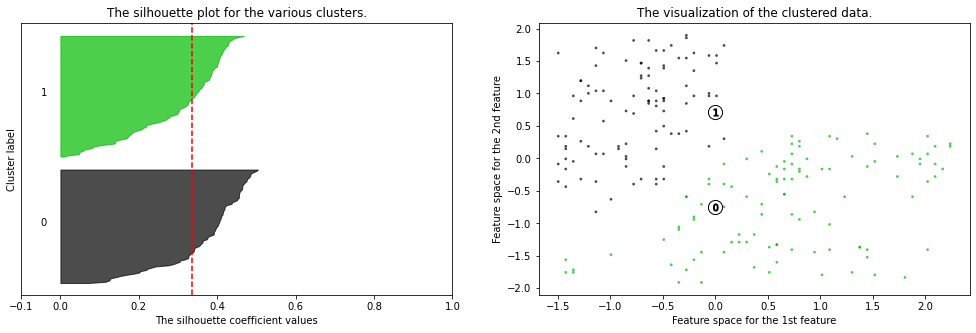

In [25]:
score_average_list = []

score_average_list.append(show_n_tell(2))

For n_clusters = 3 The average silhouette_score is : 0.35880977401117803


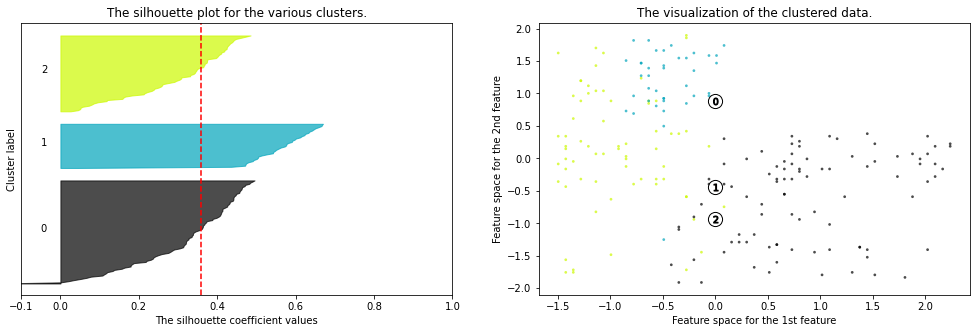

In [26]:
score_average_list.append(show_n_tell(3))

For n_clusters = 4 The average silhouette_score is : 0.4039582785148566


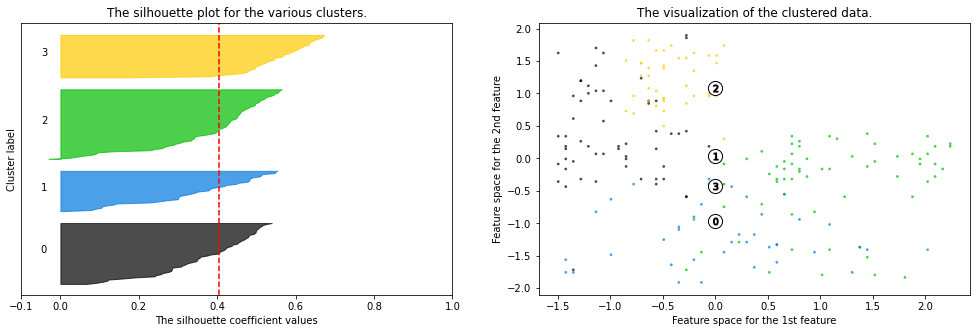

In [27]:
score_average_list.append(show_n_tell(4))

For n_clusters = 5 The average silhouette_score is : 0.41664341513732767


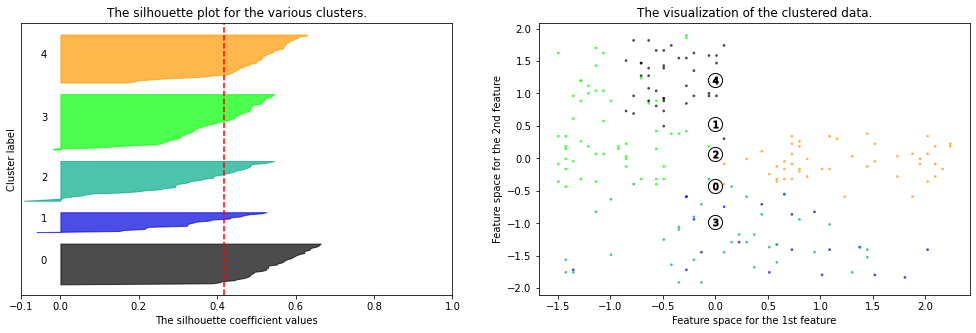

In [28]:
score_average_list.append(show_n_tell(5))

For n_clusters = 6 The average silhouette_score is : 0.42742814991580175


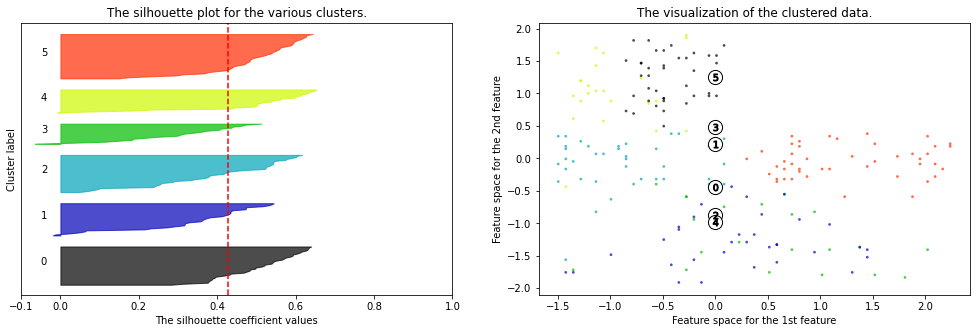

In [29]:
score_average_list.append(show_n_tell(6))

For n_clusters = 7 The average silhouette_score is : 0.4188056949620008


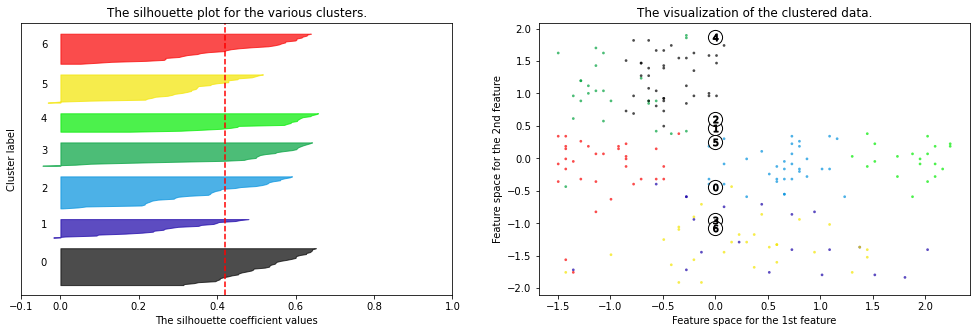

In [30]:
score_average_list.append(show_n_tell(7))

The plots for the k value at 5 or 6 looked the most even to the average. Additionally, you can tell from the scatterplot that their clusters are more contained. 

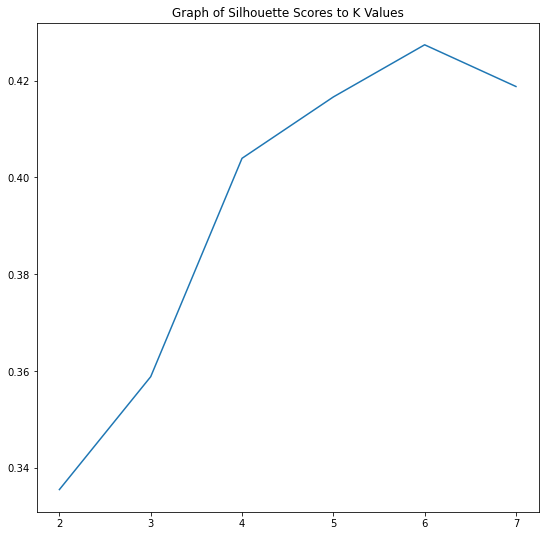

In [38]:
plt.figure(figsize = (9,9))
sns.lineplot(x = range(2,len(score_average_list)+2), y = score_average_list)
plt.title("Graph of Silhouette Scores to K Values");

After this next plot, we'll run with a k value of 6. 

### Evaluation

In [51]:
km = KMeans(n_clusters = 6, random_state=10)
yhat = km.fit_predict(X)

In [40]:
df[yhat == 0].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,39.000000,39.000000,39.000000,39.000000,39.000000
mean,162.000000,0.538462,32.692308,86.538462,82.128205
std,22.803509,0.505035,3.728650,16.312485,9.364489
min,124.000000,0.000000,27.000000,69.000000,63.000000
25%,143.000000,0.000000,30.000000,75.500000,74.500000
50%,162.000000,1.000000,32.000000,79.000000,83.000000
75%,181.000000,1.000000,35.500000,95.000000,90.000000
max,200.000000,1.000000,40.000000,137.000000,97.000000


Mixed gender group, adult, high income, high spend

In [41]:
df[yhat == 1].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,165.303030,0.424242,41.939394,88.939394,16.969697
std,21.518139,0.501890,10.179450,16.586778,9.960813
min,127.000000,0.000000,19.000000,71.000000,1.000000
25%,149.000000,0.000000,36.000000,78.000000,10.000000
50%,167.000000,0.000000,43.000000,86.000000,16.000000
75%,183.000000,1.000000,47.000000,98.000000,23.000000
max,199.000000,1.000000,59.000000,137.000000,39.000000


Opportunity (increase spend): Male, adult, high-income, low spend

In [42]:
df[yhat == 2].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,38.000000,38.000000,38.000000,38.000000,38.000000
mean,92.552632,0.631579,26.684211,57.578947,47.789474
std,26.708332,0.488852,7.117186,9.846474,9.869850
min,48.000000,0.000000,18.000000,40.000000,10.000000
25%,71.500000,0.000000,20.250000,49.500000,42.000000
50%,94.500000,1.000000,26.000000,60.000000,49.500000
75%,113.750000,1.000000,31.750000,64.000000,55.000000
max,143.000000,1.000000,40.000000,76.000000,60.000000


Opportunity (increase spend): Female, young, high than average income, average spend

In [44]:
df[yhat == 3].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,23.190476,0.619048,45.523810,26.285714,19.380952
std,12.726425,0.497613,11.766984,7.437357,12.555780
min,3.000000,0.000000,20.000000,16.000000,3.000000
25%,13.000000,0.000000,36.000000,20.000000,6.000000
50%,23.000000,1.000000,46.000000,25.000000,15.000000
75%,33.000000,1.000000,53.000000,33.000000,31.000000
max,45.000000,1.000000,67.000000,39.000000,40.000000


No opportunity here: Female, middle aged, low income and low spend

In [45]:
df[yhat == 4].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,23.041667,0.583333,25.250000,25.833333,76.916667
std,14.072728,0.503610,5.326309,8.057762,13.416138
min,1.000000,0.000000,18.000000,15.000000,39.000000
25%,11.500000,0.000000,21.000000,19.000000,72.750000
50%,23.000000,1.000000,23.500000,24.500000,76.500000
75%,34.500000,1.000000,30.000000,33.000000,83.250000
max,46.000000,1.000000,35.000000,39.000000,99.000000


Risky but important customer base: Female, young, low income, high spend

In [47]:
df[yhat == 5].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,45.000000,45.000000,45.000000,45.000000,45.000000
mean,83.777778,0.577778,56.333333,54.266667,49.066667
std,24.911561,0.499495,8.453079,8.975725,6.300794
min,41.000000,0.000000,43.000000,38.000000,35.000000
25%,64.000000,0.000000,49.000000,47.000000,45.000000
50%,81.000000,1.000000,54.000000,54.000000,49.000000
75%,103.000000,1.000000,65.000000,62.000000,55.000000
max,161.000000,1.000000,70.000000,79.000000,60.000000


Female, middle aged, median income, median spend

We have a little bit of a story here. The mall seems to do well with families and young women but suffers with middle-aged wealthy men. There is currently a risk that one of the firm's customer bases, low income young women, will dry up as a revenue source. 

We can improve the mall's outlook by either extracting more value from existing customers or by branching out to new customer segments. 

### Gaussian Mix

In [134]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import 

In [139]:
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14]
aic_list = []
bic_list = []

for n in range_n_clusters:
    gm = GaussianMixture(n_components = n).fit(X)

    aic_list.append(gm.aic(X))
    bic_list.append(gm.bic(X))

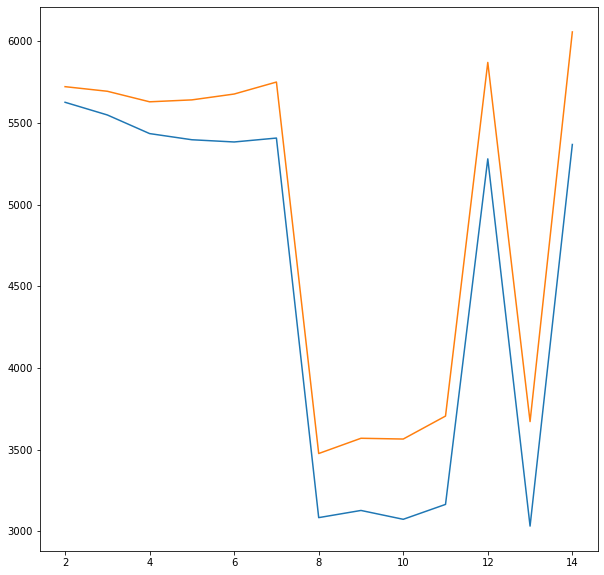

In [142]:
plt.figure(figsize = (10,10))
sns.lineplot(x = range_n_clusters, y = aic_list)
sns.lineplot(x = range_n_clusters, y = bic_list);

In [145]:
gm = GaussianMixture(n_components=8)
yhat = gm.fit_predict(X)

In [147]:
df[yhat == 0].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,21.700000,0.600000,24.850000,24.950000,81.000000
std,12.653687,0.502625,5.029126,7.287155,9.514532
min,2.000000,0.000000,18.000000,15.000000,66.000000
25%,11.500000,0.000000,21.000000,19.000000,73.000000
50%,21.000000,1.000000,23.000000,23.500000,78.000000
75%,32.500000,1.000000,29.250000,30.750000,88.250000
max,42.000000,1.000000,35.000000,38.000000,99.000000


Female, young, low income, high spend

In [148]:
df[yhat == 1].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,84.696970,0.636364,24.757576,54.363636,50.000000
std,29.759961,0.488504,5.056124,11.523938,8.291562
min,28.000000,0.000000,18.000000,28.000000,29.000000
25%,59.000000,0.000000,20.000000,46.000000,42.000000
50%,88.000000,1.000000,24.000000,57.000000,51.000000
75%,106.000000,1.000000,28.000000,62.000000,55.000000
max,143.000000,1.000000,35.000000,76.000000,65.000000


Female, young, average income and score

In [149]:
df[yhat == 2].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,151.580645,0.580645,33.000000,79.193548,82.903226
std,21.669909,0.501610,3.642344,9.267935,10.074241
min,89.000000,0.000000,27.000000,58.000000,60.000000
25%,137.000000,0.000000,30.000000,73.000000,75.000000
50%,152.000000,1.000000,32.000000,78.000000,86.000000
75%,167.000000,1.000000,35.500000,85.500000,90.500000
max,186.000000,1.000000,40.000000,99.000000,97.000000


Female, adult, high income and spend

In [150]:
df[yhat == 3].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,166.090909,0.454545,41.454545,89.090909,16.181818
std,20.694751,0.505650,11.172206,16.451375,9.422230
min,129.000000,0.000000,19.000000,71.000000,1.000000
25%,151.000000,0.000000,34.000000,78.000000,10.000000
50%,167.000000,0.000000,42.000000,86.000000,15.000000
75%,183.000000,1.000000,47.000000,98.000000,22.000000
max,199.000000,1.000000,59.000000,137.000000,39.000000


Male, middle aged, high income, low spend

In [151]:
df[yhat == 4].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,8.000000,8.000000,8.000000,8.00000,8.000000
mean,18.250000,0.625000,34.125000,23.62500,31.750000
std,14.733344,0.517549,10.588909,8.17553,10.846329
min,1.000000,0.000000,19.000000,15.00000,6.000000
25%,4.500000,0.000000,28.250000,16.75000,31.750000
50%,19.000000,1.000000,35.000000,22.50000,35.000000
75%,27.500000,1.000000,41.250000,28.25000,36.750000
max,43.000000,1.000000,48.000000,39.00000,40.000000


Female, adult, low income and spend

In [152]:
df[yhat == 5].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,25.533333,0.600000,51.133333,27.733333,15.133333
std,12.682196,0.507093,10.541528,7.629517,10.225086
min,7.000000,0.000000,35.000000,18.000000,3.000000
25%,14.000000,0.000000,44.000000,20.000000,5.500000
50%,25.000000,1.000000,52.000000,28.000000,14.000000
75%,36.000000,1.000000,59.000000,33.500000,21.500000
max,45.000000,1.000000,67.000000,39.000000,35.000000


Female, middle aged, low income and spend

In [153]:
df[yhat == 6].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,87.333333,0.549020,53.705882,55.705882,48.862745
std,23.969703,0.502543,9.769942,8.793848,6.400061
min,47.000000,0.000000,38.000000,40.000000,35.000000
25%,67.500000,0.000000,47.500000,48.000000,43.500000
50%,84.000000,1.000000,50.000000,54.000000,48.000000
75%,107.500000,1.000000,63.000000,63.000000,55.000000
max,147.000000,1.000000,70.000000,77.000000,60.000000


Mixed gender, middle aged, median income and spend

In [154]:
df[yhat == 7].describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,189.777778,0.444444,31.777778,108.666667,77.000000
std,9.297550,0.527046,3.898005,16.844881,8.077747
min,172.000000,0.000000,27.000000,87.000000,68.000000
25%,188.000000,0.000000,28.000000,101.000000,69.000000
50%,192.000000,0.000000,32.000000,103.000000,75.000000
75%,196.000000,1.000000,35.000000,120.000000,83.000000
max,200.000000,1.000000,38.000000,137.000000,91.000000


Male, adult, high income and spend

In [155]:
df['yhat'] = yhat

In [174]:
good = df[df['Spending Score (1-100)'] > 50]
bad = df[df['Spending Score (1-100)'] <50]
goal = df[df['Spending Score (1-100)'] > 50]['yhat'].value_counts()

Our valuable customer segments (based on spend score by cluster) are:

1. Working age high-income women, who make up 15.5% of the population

2. Middle-aged couples of average income. They make up 10% of the population.

3. Young women with low income. They also make up 10% of the population.

4. Young women with average income. They represent 16.5% of the population.

5. Young men with 6-digit income. They represent less than 5% of the population. 

The customer segments we wish to improve appeal with or avoid are:

1. Middle aged men with high income; they represent 17% of the population. 

2. Middle-aged couples of average income and spend. They make up 25.5% of the population. 

3. Middle-aged women with low income. They make up 7.5% of the population.

4. Young women of average income. They make up 17% of the population. 

## Conclusions and Recommendations

### Conclusions

Based on the data presented, our best strategy would be to continue marketing our services towards young to middle-aged women. They are the customer segments that this mall seems to rely on extensively. 

There are two customer segments that provide opportunities for us to expand: middle aged men with high income and middle aged couples.

The first opportunity is more risky; these individuals visit the mall frequently enough to represent 17% of the population, but they do not spend. We need to find a way to reach out/appeal to this new customer category. 

Second, we have a few clusters that represent the customer groups, but they are separated by the amount they spend. This means that there is room for improvement in the middle aged women and middle aged couple categories. 

### Further Data Needs

1. External Data: So far we've looked at a sample of people who shop at the mall. How do the demographics of our customer base compare to the municipality that we are situated in? This information would show who we appeal to within the town's population. Currently we are looking at conversion, but we may also want to visit the idea of bringing more people into the mall in general.

2. Time series: Both in terms of trend and seasonality, how are our customer segments reacting to changing business offerings? Its well known that malls are hurting. One of our most important customer segments is low-income young women; is that revenue source at risk of drying up? Alternatively, seasonality. Do each of our customer groups change their spending behavior throughout the year? Who should know if that is the case and when (if so). 